In [1]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import SimpleITK as sitk
from pathlib import Path
from pprint import pprint

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

from torch.optim import Adam
from transformers import get_cosine_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns
from pycm import ConfusionMatrix


from sklearn.metrics import classification_report



random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [2]:
from models.cls_models import make_efficientnet
from losses import FocalLoss
from train_pipelines import train_test
from datasets import BeginDetectorDataset, BeginDetectorDataset_for_infer

# Data

In [3]:
base_data_path = os.path.join(Path(os.getcwd()).parent, 'DICOM_xy_position', 'Nii_files')
df_path = os.path.join(base_data_path, 'slices.xlsx')
df = pd.read_excel(df_path)
df = df[df.Name != "KURDUMOV.nii"] # broken file
df['Name'] = df.Name.apply(lambda x: os.path.join(base_data_path, x))
df

,Name,Begin,End1vertebra,End2vertebra,Sex,Age,x_center,y_center,Strange Scale Data
0,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,56,4,NONE,m,26,273,293,0
1,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,94,54,14,f,18,261,313,0
2,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,157,116,75,f,25,259,346,0
3,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,328,284,240,m,30,250,285,0
4,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,291,248,209,m,35,231,327,0
...,...,...,...,...,...,...,...,...,...
219,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,71,29,NONE,f,37,260,310,0
220,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,90,44,NONE,NONE,45,261,332,0
221,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,91,49,6,NONE,39,259,263,0
222,/media/dmitriy/main/data/DICOM_Sechenov/DICOM_...,85,41,6,f,42,260,278,0


In [4]:
ds = BeginDetectorDataset(df, 10, 2, 'train')
batch, targets = next(iter(ds))
print(batch.shape)

# for i in range(batch.shape[0]):
#     plt.imshow(batch[i, 0])
#     plt.title(targets[i])
#     plt.show()

def collate_fn(batch):
    images = torch.cat([tpl[0] for tpl in batch], axis=0)
    target = torch.cat([tpl[1] for tpl in batch], axis=0)
    return images, target

# dl = DataLoader(ds, shuffle=False, batch_size=2, num_workers=0, collate_fn=collate_fn)
# out = next(iter(dl))
# out[0].shape, out[1].shape


# infer_ds = BeginDetectorDataset_for_infer(df.loc[0, 'Name'])
# img, i = infer_ds[0]

torch.Size([30, 1, 128, 128])


# Train

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = make_efficientnet(2, device, i=1)

model_file = 'effnet_0.pth'
# model = torch.load(model_file)

model.to(device)
print(device)

Loaded pretrained weights for efficientnet-b1
cuda:0


In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index()
test_df = test_df.reset_index()

train_dataset = BeginDetectorDataset(train_df, 20, 0.6, 'train', 100, resize_shape)
test_dataset = BeginDetectorDataset(test_df, 20, 0.6, 'test', 100, resize_shape)

trainloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0, collate_fn=collate_fn, pin_memory=False)
testloader = DataLoader(test_dataset, shuffle=False, batch_size = batch_size, num_workers=0, collate_fn=collate_fn, pin_memory=False)

In [11]:
resize_shape = (512, 512)

batch_size = 1
num_epochs = 10
optimizer = Adam(model.parameters(), lr = 0.000001) #, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / batch_size * num_epochs)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/batch_size*5, num_training_steps=num_train_steps)

    

loss_fn = FocalLoss()
# loss_fn = torch.nn.CrossEntropyLoss()

train_loss, test_loss = train_test(
    model, 
    optimizer,
    scheduler,
    trainloader,
    testloader,
    loss_fn,
    num_epochs=num_epochs,
    verbose=True, 
    device=device,
)

torch.save(model, model_file)

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train loss: 0.005691761611960828, Test loss: tensor(5.8658e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Train loss: 0.005565188229084015, Test loss: tensor(5.7771e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, Train loss: 0.005317238150164485, Test loss: tensor(5.5776e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, Train loss: 0.004979186388663947, Test loss: tensor(5.1765e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, Train loss: 0.004577168240211904, Test loss: tensor(4.7990e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5, Train loss: 0.004100114572793245, Test loss: tensor(4.3652e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6, Train loss: 0.003644719528965652, Test loss: tensor(4.0393e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, Train loss: 0.003258502602111548, Test loss: tensor(3.8473e-05)


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, Train loss: 0.0030798304290510716, Test loss: tensor(3.7190e-05)


Testing: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


Epoch: 9, Train loss: 0.0029972581448964777, Test loss: tensor(3.7404e-05)


In [11]:
torch.save(model, model_file)

100%|██████████| 240/240 [00:02<00:00, 80.90it/s]

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.99      0.94      0.96       199\n'
 '           1       0.76      0.95      0.85        41\n'
 '\n'
 '    accuracy                           0.94       240\n'
 '   macro avg       0.88      0.95      0.91       240\n'
 'weighted avg       0.95      0.94      0.94       240\n')


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

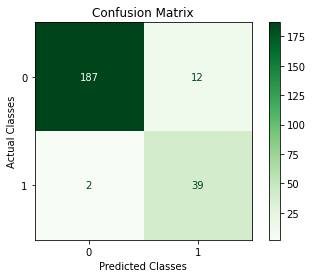

In [12]:
# row = df.loc[6]
row = train_df.loc[6]
# row = test_df.loc[1]

model.eval()
infer_ds = BeginDetectorDataset_for_infer(row.Name, shape=resize_shape)


preds = []
for img, i in tqdm(infer_ds, position=0, leave=True):
    with torch.no_grad():
        resp = model(img.to(device))
        preds.append(resp.cpu().argmax(axis=1).item())
        
preds = np.array(preds)
down_line = -1 if isinstance(row['End1vertebra '], str) else row['End1vertebra ']
tr = [(1 if down_line<i and i<row['Begin'] else 0) for i in range(infer_ds.image.shape[0])]
tr = np.array(tr)

from sklearn.metrics import classification_report
pprint(classification_report(tr, preds))

cm = ConfusionMatrix(tr,preds)
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

100%|██████████| 178/178 [09:56<00:00,  3.35s/it]

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.99      0.77      0.87     40393\n'
 '           1       0.45      0.95      0.61      7892\n'
 '\n'
 '    accuracy                           0.80     48285\n'
 '   macro avg       0.72      0.86      0.74     48285\n'
 'weighted avg       0.90      0.80      0.82     48285\n')


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

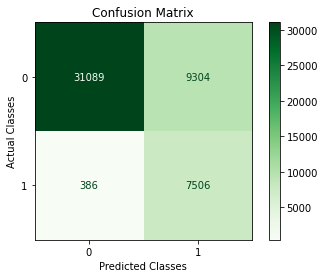

In [19]:
model.eval()

preds = []
truth = []
packs = []

for i in tqdm(range(train_df.shape[0]), position=0, leave=True):
    row = train_df.loc[i]

    infer_ds = BeginDetectorDataset_for_infer(row.Name, shape=resize_shape)

    pred_p = []
    for img, i in infer_ds:
        with torch.no_grad():
            resp = model(img.to(device))
            resp = resp.cpu().argmax(axis=1).item()
            preds.append(resp)
            pred_p.append(resp)

    down_line = -1 if isinstance(row['End1vertebra '], str) else row['End1vertebra ']
    tr = [(1 if down_line<i and i<row['Begin'] else 0) for i in range(infer_ds.image.shape[0])]
    packs.append([tr, pred_p])
    truth += tr


preds = np.array(preds)
truth = np.array(truth)

from sklearn.metrics import classification_report
pprint(classification_report(truth, preds))

cm = ConfusionMatrix(truth, preds)
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")

/home/dmitriy/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

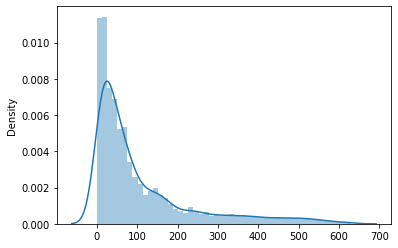

In [33]:
errors_ids = []
for tr, pred in packs:
    flags = (np.array(tr) != np.array(pred))
    errors_ids += np.where(flags)[0].tolist()
    
sns.distplot(errors_ids)

In [41]:
from collections import Counter

errors_ids = []
for tr, pred in packs:
    first_tr = np.where(tr)[0][0]
    last_tr = np.where(tr)[0][-1]
    flags = np.where((np.array(tr) != np.array(pred)))[0]
    errors_ids += [ 0 if f<=first_tr else (2 if f >= last_tr else 1) for f in flags]
    

Counter(errors_ids)

Counter({0: 5296, 2: 4078, 1: 316})

100%|██████████| 45/45 [02:24<00:00,  3.20s/it]

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.99      0.83      0.90      9916\n'
 '           1       0.53      0.95      0.68      1980\n'
 '\n'
 '    accuracy                           0.85     11896\n'
 '   macro avg       0.76      0.89      0.79     11896\n'
 'weighted avg       0.91      0.85      0.87     11896\n')


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

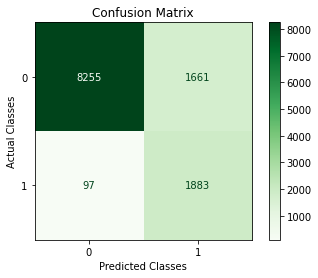

In [14]:
model.eval()

preds = []
truth = []
packs = []

for i in tqdm(range(test_df.shape[0]), position=0, leave=True):
    row = train_df.loc[i]

    infer_ds = BeginDetectorDataset_for_infer(row.Name, shape=resize_shape)

    pred_p = []
    for img, i in infer_ds:
        with torch.no_grad():
            resp = model(img.to(device))
            resp = resp.cpu().argmax(axis=1).item()
            preds.append(resp)
            pred_p.append(resp)

    down_line = -1 if isinstance(row['End1vertebra '], str) else row['End1vertebra ']
    tr = [(1 if down_line<i and i<row['Begin'] else 0) for i in range(infer_ds.image.shape[0])]
    packs.append([tr, pred_p])
    truth += tr


preds = np.array(preds)
truth = np.array(truth)

from sklearn.metrics import classification_report
pprint(classification_report(truth, preds))

cm = ConfusionMatrix(truth, preds)
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib")